In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
import random

names = open('Indian_Names_Cleaned.txt', 'r').read().splitlines()
random.shuffle(names)
names[:8]

['pankajsheel',
 'ruplal',
 'khanchan',
 'beeti',
 'premchand',
 'prasanta',
 'sahun',
 'kushum']

In [ ]:
len(names)

6486

In [7]:
char = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(char)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [65]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):
  X, Y = [], []

  for n in names:
    context = [0] * block_size
    for ch in n + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([38197, 3]) torch.Size([38197])
torch.Size([4747, 3]) torch.Size([4747])
torch.Size([4751, 3]) torch.Size([4751])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
B2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 26.6586
  10000/ 200000: 1.9278


KeyboardInterrupt: 

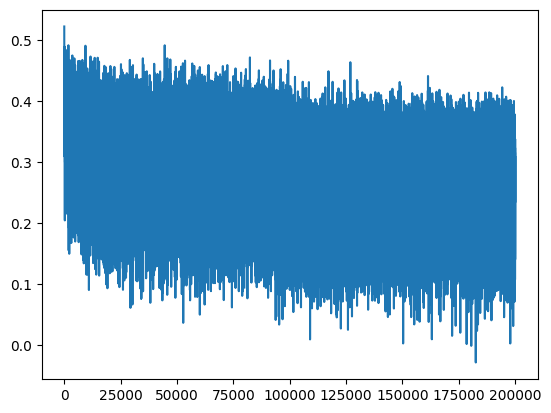

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + B1) # (N, n_hidden)
  logits = h @ W2 + B2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.810422658920288
val 1.810422658920288


In [ ]:
# g = torch.Generator().manual_seed(6911510410511697)
g = torch.Generator().manual_seed(41918129625146519)
for _ in range(26):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + B1)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    # sample
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shifting the context window
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample "." roken, break
    if ix == 0:
      break

  print('.'.join(itos[i] for i in out))

l.o.k..
p.a.s.p.a.n..
n.i.r.w.a.t.a.n.e.e.l.a.l..
r.i.m.a..
j.a.m..
p.a.r.v.e.e.r..
r.e.n.d.e.r..
a.p.t.a..
s.a.n.i..
j.a.f.r.i.n.k.a.j..
n.e.n.d.e.r..
a.j.a.r.i..
y.a.d.h.n.a.t.h..
p.r.a.k.h..
d.e.v.i.s.h..
r.a.j..
o.m.e.s.h..
r.a.t.a.k.i.r.a.m.b.o..
m.a.n.k.a.d.i.r.e.n.d.r.a..
t.i.n.k.a..
s.u.r.e.n.d.e.r.t.u..
r.a.j.e.n.d.u..
y.a.s..
o.m.p.n.a.r.m.e.e.s.a.v.i.r..
r.a.g.h.u.r.a.n.g..
s.h.a.t.e.e.k.a.n.d.e.r.w.i.t.h.a.l.y.a.d.a.r..


Getting the logits right at the first time

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
B2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 4.2602


In [ ]:
h

NameError: name 'h' is not defined

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
# doubt

In [3]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [4]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)



  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [5]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [10]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(78678958) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [12]:
max_steps = 200000
batch_size = 32
lossi = []
d = []

In [24]:
# batch construction

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [60]:
# forward pass

emb = C[Xb]
x = emb.view(emb.shape[0], -1)
for layer in layers:
  x = layer(x)
loss = F.cross_entropy(x, Yb)

loss

tensor(2.8884, grad_fn=<NllLossBackward0>)

In [61]:
 # backward pass

for layer in layers:
  layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
for p in parameters:
  p.grad = None
loss.backward()

In [62]:
# update

for p in parameters:
  p.data += -0.1 * p.grad

In [63]:
lossi.append(loss.log10().item())
with torch.no_grad():
  d.append([((0.1*p.grad).std() / p.data.std()).log10().item() for p in parameters])

In [64]:
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    d.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/ 200000: 3.2000
  10000/ 200000: 2.0423
  20000/ 200000: 1.8189
  30000/ 200000: 2.0523
  40000/ 200000: 2.0751
  50000/ 200000: 1.7707
  60000/ 200000: 2.0996
  70000/ 200000: 1.7919
  80000/ 200000: 2.3742
  90000/ 200000: 1.5232
 100000/ 200000: 2.1576
 110000/ 200000: 1.7491
 120000/ 200000: 2.1291
 130000/ 200000: 1.6836
 140000/ 200000: 2.2442
 150000/ 200000: 1.8911
 160000/ 200000: 1.3982
 170000/ 200000: 1.7864
 180000/ 200000: 1.6732
 190000/ 200000: 1.8390


In [72]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:

      emb = C[torch.tensor([context])]
      x = emb.view(emb.shape[0], -1)

      for layer in layers:
        x = layer(x)

      if torch.isnan(x).any() or torch.isinf(x).any():
          print("Warning: NaN or Inf detected in logits!", x)
          x = torch.nan_to_num(x, nan=0.0, posinf=1e-6, neginf=1e-6)

      logits = torch.clamp(x, min=-10, max=10)
      probs = F.softmax(logits / 1.0, dim=1)

      if torch.isnan(probs).any() or torch.isinf(probs).any() or (probs < 0).any():
          print("Warning: Invalid values in probs!", probs)
          probs = torch.nan_to_num(probs, nan=0.0, posinf=1e-6, neginf=1e-6)


      if not torch.allclose(probs.sum(dim=1), torch.tensor(1.0), atol=1e-3):
          print("Warning: probs do not sum to 1!", probs.sum(dim=1))
          probs = probs / probs.sum(dim=1, keepdim=True)

      ix = torch.multinomial(probs, num_samples=1, generator=g).item()

      context = context[1:] + [ix]
      out.append(ix)

      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

<ipython-input-4-74e6fe63dffe>:20: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  xvar = x.var(0, keepdim=True) # batch variance
